In [2]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import time, os, sys
from tqdm import tqdm

from matplotlib import pyplot as plt
from utils.basic_utils import *
from utils.pricing import load_px_close, discret_rets, sample_wgts
from utils.pricing import dummy_col, rename_col, px_fwd_rets, px_mom_feats, px_mom_co_feats_light
from utils.pricing import eq_wgt_indices, to_index_form, get_symbol_pricing, get_return_intervals
from utils.fundamental import pipe_transform_df, chain_divide, chain_scale
from utils.fundamental import chain_outlier, chain_post_drop, chain_wide_transform
from utils.fundamental import chain_eps_estimates, chain_eps_revisions, chain_rec_trend
from utils.fundamental import load_append_ds, get_daily_ts, numeric_cols, filter_cols
from utils.ml_utils import show_fi, print_cv_results

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [3]:
# feature mapping for different datasets
ds_dict = {
    'fin_data': {
        'path': 'summary-categories/financialData/',
        'index': 'storeDate',
        'features': [
            'numberOfAnalystOpinions', 'currentPrice', 'revenuePerShare', 'totalCashPerShare',
            'currentRatio', 'debtToEquity', 'earningsGrowth', 'ebitda', 
            'ebitdaMargins', 'freeCashflow', 'grossMargins', 
            'grossProfits', 'operatingCashflow', 'operatingMargins', 'profitMargins', 
            'quickRatio', 'recommendationMean', 
            'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 
            'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'totalCash', 'totalDebt', 'totalRevenue', 
#             'financialCurrency', 'recommendationKey',              
            'symbol', ],
        'scale': [
            'freeCashflow', 'operatingCashflow', 'ebitda', 
            'totalCash', 'totalDebt', 'totalRevenue', 'grossProfits', ],
        'divide': ('currentPrice', 
                   ['revenuePerShare', 'totalCashPerShare', 
                    'targetLowPrice', 'targetMeanPrice', 
                    'targetMedianPrice', 'targetHighPrice', ]),
        'outlier': 'quantile',
        'post_drop': ['numberOfAnalystOpinions'],
    },    
    'key_statistics': {
        'path': 'summary-categories/defaultKeyStatistics/',
        'index': 'storeDate',
        'features': [
            'beta', 'earningsQuarterlyGrowth', 
            'enterpriseToEbitda', 'enterpriseToRevenue', 'enterpriseValue', 
            'netIncomeToCommon', 'pegRatio', 
            'shortPercentOfFloat', 'shortRatio', 'heldPercentInsiders', 
            'heldPercentInstitutions', 'symbol', ],
        'scale': ['enterpriseValue', 'netIncomeToCommon', ],
        'outlier': 'quantile', 
    },
    'day_quote': {
        'path': 'quote/csv/',
        'index': 'storeDate',
        'features': [
            'regularMarketChangePercent',
            'averageDailyVolume10Day', 'averageDailyVolume3Month', 'regularMarketVolume', 
            'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent',
            'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent', 
            'forwardPE', 'trailingPE', 'priceToBook', 'marketCap', 'symbol', ],
        'scale': ['marketCap', ],
        'divide': ('regularMarketVolume', ['averageDailyVolume10Day', 'averageDailyVolume3Month']),
        'outlier': 4, 
    },        
    'eps_trend': {
        'path': 'summary-categories/epsTrend/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],        
        'features': [
            'period', 'growth', 
            'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo', 
            'symbol', ],
        'pivot_cols': ['growth', 'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo'],
        'outlier': 'quantile',
    },
    'eps_estimates': {
        'path': 'summary-categories/earningsEstimate/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],
        'features': ['period', 'avg', 'low', 'high', 'symbol', ],
        'pivot_cols': ['avg', 'low', 'high'],
        'outlier': 'quantile', 
    },
    'eps_revisions': {
        'path': 'summary-categories/epsRevisions/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],
        'features': [
            'period', 'growth', 'upLast7days', 'upLast30days', 'downLast30days', 
            'symbol', ],
        'pivot_cols': ['growth', 'upLast7days', 'upLast30days', 'downLast30days'],
        'outlier': 3, 
    },
    'spy_trend': {
        'path': 'summary-categories/indexTrend/',
        'index': 'storeDate',
        'features': [
            '0q', '+1q', '0y', '+1y', '+5y', '-5y', 
            'peRatio', 'pegRatio', 'symbol', ]
    },
    'net_purchase': {
        'path': 'summary-categories/netSharePurchaseActivity/',
        'index': 'storeDate',
        'features': [
            'netPercentInsiderShares', 'buyPercentInsiderShares', 'sellPercentInsiderShares', 
            'symbol', ]
    },    
    'rec_trend': {
        'path': 'summary-categories/recommendationTrend/',
        'index': 'storeDate',
        'periods': ['-1m', '-2m'],
        'features': [
            'period', 'strongBuy', 'buy', 'hold', 'sell', 'strongSell', 
            'symbol', ],
        'pivot_cols': ['strongBuy', 'buy', 'hold', 'sell', 'strongSell'],
        'outlier': 10,
    },
}

# pre-processing pipeline
fn_pipeline = {
    'fin_data': [chain_scale, chain_divide, chain_post_drop, chain_outlier],
    'key_statistics': [chain_scale, chain_outlier],
    'day_quote': [chain_divide, chain_scale, chain_outlier],
    'eps_trend': [chain_wide_transform, chain_eps_estimates, chain_outlier],
    'eps_estimates': [chain_wide_transform, chain_eps_estimates, chain_outlier],
#     'eps_revisions': [chain_wide_transform, chain_outlier],
#     'spy_trend':[lambda x, y: x],
#     'net_purchase':[lambda x, y: x],    
#     'rec_trend': [chain_wide_transform, chain_rec_trend, chain_outlier],
}

### Context data

In [4]:
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = config['companies']

context = {    
    'tickers': tickers,
    'fn_pipeline': fn_pipeline,
    'ml_path': '../ML/', 
    'model_name': 'bottomup_NN.pkl',
    'tmp_path': '../tmp/',
    'ds_name': 'co-bottomup-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'bottomup_NN_train_cols.npy',
    'look_ahead': 20,
    'look_back': 252,    
    'smooth_window': 10,
    'load_ds': True,
    'scale': True,
    'test_size': .20,
    'verbose': True,    
    's3_path': f'recommend/bottomup_ML/',
    'verbose': 0,
    'neuron_mult': 5,
    'hidden_layers': 3,
    'max_iter': 100,
}

In [7]:
# for notebook only
ec2_IP = '54.201.151.162'
remote_path = config['remote_path']
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
!scp -i ~vveiga/.ssh/qc_infra.pem ubuntu@{ec2_IP}:{remote_path}/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-ds                                100%   18MB   4.6MB/s   00:03    


In [5]:
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

stacked_px = px_close.stack().to_frame().rename(columns={0: 'close'}) # stack date + symbol
stacked_px.index.set_names(['storeDate', 'symbol'], inplace=True) # reindex
context['close_px'] = stacked_px

prices = px_close.dropna(subset=[bench])[tickers]
look_ahead = context['look_ahead']
cut_range = get_return_intervals(prices, look_ahead, tresholds=[0.25, 0.75])
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
f'Return intervals {cut_range}'

<class 'pandas.core.frame.DataFrame'>
Index: 4672 entries, 2004-05-02 to 2019-05-01
Columns: 1285 entries, 0700.HK to KRW=X
dtypes: float32(1285)
memory usage: 22.9+ MB
px_close.info() None


'Return intervals (-inf, -0.07837450318038464, -0.05162740498781204, 0.05468173325061798, 0.08756376802921295, inf)'

In [6]:
# latest quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

quotes = load_csvs('quote_consol', [tgt_date])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-01
Loading file quote/csv/2019-05-01
Loading file summary-categories/assetProfile


In [7]:
# Smaller subset for testing
tickers = list(profile.loc[profile.sector.isin(['Healthcare']), 'symbol'])
context['tickers'] = tickers

### Final

In [8]:
def create_ds(context):
    # context variables
    key = context['key']
    load_ds = context['load_ds']
    load_dates = context['load_dates']
    tmp_path = context['tmp_path']
    
    # Load or append missing data to local dataset
    fname = tmp_path + key
    if load_ds & os.path.isfile(fname):
        daily_df = pd.read_parquet(fname)
        # compare and load missing dates
        missing_dates = list(
            set(daily_df.index.unique().date.astype(str))\
                .symmetric_difference(load_dates))
        if len(missing_dates) > 0: # retrieve missing dates
            append_df = get_daily_ts(key, ds_dict, missing_dates)
            daily_df = pd.concat([daily_df, append_df], axis=0) # append to daily
            # daily_df.drop_duplicates(inplace=True)
            daily_df.to_parquet(tmp_path + key) # and persist to drive for next time
    else:
        # file does not exist, retrieves all dates
        daily_df = get_daily_ts(key, ds_dict, load_dates)
        num_cols = excl(daily_df.columns, ['symbol', 'period'])
        daily_df.loc[:, num_cols] = daily_df[num_cols].astype(np.float32)
        # Make index a flat date, easier to index save down to drive if refresh pricing
        os.makedirs(tmp_path, exist_ok=True)
        # daily_df.drop_duplicates(inplace=True)
        daily_df.to_parquet(fname)
    daily_df.index.name = ds_dict[key]['index']
    daily_df.index = daily_df.index.date
    
    return daily_df

In [9]:
def create_pre_process_ds(context):
    
    # join all datasets
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')

    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()

    # generic price momentum statistics
    super_list = []
    for key in ('fin_data', 'key_statistics', 'day_quote', 'eps_trend', 'eps_estimates'):
        print(f'adding {key}')
        context['key'] = key
        context['pre'] = key.split('_')[0] # append preffix
        context['ds_dict'] = ds_dict[key]
        load_dates = read_dates(ds_dict[key]['path'], '.csv')
        context['load_dates'] = load_dates
        df = create_ds(context)
        df = df.loc[df.symbol.isin(tickers),:]
        processed_df = pipe_transform_df(df, key, fn_pipeline, context)
        if key in ('fin_data', 'key_statistics', 'day_quote'):
            processed_df.index.name = 'storeDate'
            processed_df = processed_df.reset_index().set_index(['storeDate', 'symbol'])
        super_list.append(processed_df.drop_duplicates())

    processed_df = pd.concat(super_list, axis=1)
    print(f'processed_df.shape {processed_df.shape}')

    # company specific statistics 
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                ft_df.index.name = 'storeDate'
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    px_mom_df = pd.concat(super_list, axis=0)

    px_mom_df = px_mom_df.reset_index().set_index(['storeDate', 'symbol']).sort_index().dropna()
    joined_df = pd.concat([processed_df, px_mom_df], join='inner', axis=1)
    print(f'joined_df.shape {joined_df.shape}')

    # basic scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
    joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df.reset_index('symbol')

In [10]:
def train_ds(context):
    
    verbose = context['verbose']
    ml_path, model_name = context['ml_path'], context['model_name']
    trained_cols = context['trained_cols']    
    look_ahead, look_back, smooth_window = context['look_ahead'], context['look_back'], context['smooth_window']
    f'{look_ahead} days, {look_back} days, {smooth_window} days'

    joined_df = create_pre_process_ds(context)

    # if we want to limit training set
    # index = joined_df.sort_index().index.unique()[-look_back:]
    # joined_df = joined_df.loc[index, :]
    # joined_df.shape

    # calculation of forward returns
    Y = px_close.loc[:, tickers].pct_change(look_ahead).shift(-look_ahead)
    # Y = Y.rolling(smooth_window).mean() # smooth by the same length
    Y = Y[~(Y.isna().all(1))]
    Y = Y.loc[joined_df.index.unique(), :]

    # reshapes to include symbol in index in additional to date
    Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
    Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
    # somwhat repetitive with steps above but performs faster
    Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
    print('Y_df.shape', Y_df.shape)

    # re-index processed df on storeDate and symbol to have similar indices
    joined_df.index.set_names('storeDate', inplace=True)
    joined_df.set_index(['symbol'], append=True, inplace=True)
    print('joined_df.shape', joined_df.shape)

    # add Y values to processed df fast without having to loop
    joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

    # joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
    # joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

    # discretize Y-variable
    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
    print('joined_df.shape', joined_df.shape)
    print(sample_wgts(joined_df[y_col]))

    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    # joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
    train_df = joined_df.reset_index(drop=True)
    train_df.shape

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break # just one split

    # skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    # for train_index, test_index in skf.split(X, y):
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #     break

    # MLPClassifier
    neuron_mult = context['neuron_mult']
    max_iter = context['max_iter']
    max_iter = context['max_iter']
    neurons = X_train.shape[1] * neuron_mult
    hidden_layers = tuple([neurons for x in range(context['hidden_layers'])])

    mlp_params = {
        'solver': 'adam', 'max_iter': max_iter, #reduced from 600 for testing
        'hidden_layer_sizes': hidden_layers,
        'n_iter_no_change': 10, 'verbose': True, 'random_state': None, }
    clf = MLPClassifier(**mlp_params)
    print(clf)
    clf.fit(X_train, y_train)
    print(f'Train {clf.score(X_train, y_train)}, Test {clf.score(X_test, y_test)}')

    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)

    # save model
    os.makedirs(ml_path, exist_ok=True)
    fname = ml_path + model_name
    joblib.dump(clf, fname)
    print('Saved ', fname)

In [11]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']

    joined_df = create_pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index[-1], :]
    print('pred_X.shape', pred_X.shape)
    
    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    fname = ml_path + model_name
    clf = joblib.load(fname) # load latest models
    print('Loaded', fname)

    preds = clf.predict(pred_X[sorted_cols].iloc[:, :-1])
    pred_class = np.array([fwd_ret_labels.index(x) for x in preds])
    pred_df['pred_class'] = pred_class
    pred_df['pred_label'] = preds
    probs = clf.predict_proba(pred_X[sorted_cols].iloc[:, :-1])
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=clf.classes_)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

#### Train

In [ ]:
    verbose = context['verbose']
    ml_path, model_name = context['ml_path'], context['model_name']
    trained_cols = context['trained_cols']    
    look_ahead, look_back, smooth_window = context['look_ahead'], context['look_back'], context['smooth_window']
    f'{look_ahead} days, {look_back} days, {smooth_window} days'

    joined_df = create_pre_process_ds(context)

    # if we want to limit training set
    # index = joined_df.sort_index().index.unique()[-look_back:]
    # joined_df = joined_df.loc[index, :]
    # joined_df.shape

    # calculation of forward returns
    Y = px_close.loc[:, tickers].pct_change(look_ahead).shift(-look_ahead)
    # Y = Y.rolling(smooth_window).mean() # smooth by the same length
    Y = Y[~(Y.isna().all(1))]
    Y = Y.loc[joined_df.index.unique(), :]

    # reshapes to include symbol in index in additional to date
    Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
    Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
    # somwhat repetitive with steps above but performs faster
    Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
    print('Y_df.shape', Y_df.shape)

    # re-index processed df on storeDate and symbol to have similar indices
    joined_df.index.set_names('storeDate', inplace=True)
    joined_df.set_index(['symbol'], append=True, inplace=True)
    print('joined_df.shape', joined_df.shape)

    # add Y values to processed df fast without having to loop
    joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

    # joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
    # joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

    # discretize Y-variable
    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
    print('joined_df.shape', joined_df.shape)
    print(sample_wgts(joined_df[y_col]))

    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    # joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
    train_df = joined_df.reset_index(drop=True)
    train_df.shape

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break # just one split

    # skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    # for train_index, test_index in skf.split(X, y):
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #     break

    # MLPClassifier
    neuron_mult = context['neuron_mult']
    max_iter = context['max_iter']
    max_iter = context['max_iter']
    neurons = X_train.shape[1] * neuron_mult
    hidden_layers = tuple([neurons for x in range(context['hidden_layers'])])

    mlp_params = {
        'solver': 'adam', 'max_iter': max_iter, #reduced from 600 for testing
        'hidden_layer_sizes': hidden_layers,
        'n_iter_no_change': 10, 'verbose': True, 'random_state': None, }
    clf = MLPClassifier(**mlp_params)
    print(clf)
    clf.fit(X_train, y_train)
    print(f'Train {clf.score(X_train, y_train)}, Test {clf.score(X_test, y_test)}')

    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)

    # save model
    os.makedirs(ml_path, exist_ok=True)
    fname = ml_path + model_name
    joblib.dump(clf, fname)
    print('Saved ', fname)

In [243]:
%time train_ds(context)

Sectors: 1, Industries: 10
adding fin_data
adding key_statistics
adding day_quote
adding eps_trend


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


adding eps_estimates


2it [00:00, 12.15it/s]

processed_df.shape (16428, 67)


136it [00:12, 11.15it/s]


joined_df.shape (15542, 85)


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWar

Y_df.shape (19560, 1)
joined_df.shape (15542, 85)
joined_df.shape (13430, 86)
neutral   0.50
bear      0.19
bull      0.12
long      0.09
short     0.09
Name: fwdReturn, dtype: float64
Training for 160 dates, 0.6 years
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(425, 425, 425), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)
Iteration 1, loss = 1.28207587
Iteration 2, loss = 1.14166617
Iteration 3, loss = 1.05970584
Iteration 4, loss = 0.98610120
Iteration 5, loss = 0.92236149
Iteration 6, loss = 0.85939782
Iteration 7, loss = 0.80585473
Iteration 8, loss = 0.75515523
Iteration 9, loss = 0.71095463
Iteration 10, loss = 0.66413958
Iterati

#### Predict

In [12]:
%time pred_df = predict_ds(context)

Sectors: 1, Industries: 10
adding fin_data
adding key_statistics
adding day_quote
adding eps_trend


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


adding eps_estimates


2it [00:00, 13.85it/s]

processed_df.shape (16428, 67)


136it [00:10, 13.04it/s]


joined_df.shape (15542, 85)


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


pred_X.shape (132, 86)
pred_X.shape (132, 86)
Loaded ../ML/bottomup_NN.pkl
Saved recommend/bottomup_ML/2019-05-01.csv
CPU times: user 30.8 s, sys: 2.81 s, total: 33.6 s
Wall time: 22.3 s


#### Store / Read S3

In [14]:
s3_path = context['s3_path']

In [15]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tgt_date}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

In [ ]:
pred_df.head()

In [17]:
# recommendation distribution
pd.value_counts(pred_df.pred_label)

neutral    93
bear       19
bull       10
long        5
short       5
Name: pred_label, dtype: int64

In [18]:
# top 3 picks by label
label_mask = pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])
pred_df.loc[label_mask]\
    .sort_values(by='confidence', ascending=False)\
    .groupby(by='pred_label').head(5)\
    .sort_values(by='pred_label')

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-01,BIIB,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-01,GWPH,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-01,MOH,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-01,CMD,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-01,AMED,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-01,THC,4,bull,1.00,0.00,0.00,0.00,0.00,1.00
2019-05-01,MMSI,4,bull,1.00,0.00,0.00,0.00,0.00,1.00
2019-05-01,CLVS,4,bull,1.00,0.00,0.00,0.00,0.00,1.00
2019-05-01,ILMN,4,bull,1.00,0.00,0.00,0.00,0.00,1.00


### Other experiments 

In [1018]:
# fiftyTwoWeekHighChangePercent
# fiftyTwoWeekLowChangePercent
mask = (pred_df.soft_confidence > 0.7)\
    & (pred_df.soft_pred_label.isin(['long', 'bull']))

pd.concat([
    quotes.loc[:, 'fiftyTwoWeekHighChangePercent'].rank(ascending=False, pct=True),
    pred_df[mask].loc[:, ['symbol', 'soft_confidence']].set_index('symbol').rank(pct=True)
], axis=1).dropna().mean(1).sort_values(ascending=False)

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


PRLB   0.93
PTEN   0.93
WAB    0.92
IVZ    0.90
DLX    0.89
TIF    0.89
UNIT   0.88
PCH    0.87
MTDR   0.87
FTI    0.87
WB     0.86
IPGP   0.86
AAL    0.85
CONE   0.85
YY     0.85
LYB    0.85
URBN   0.84
PDCE   0.84
FLR    0.83
HAL    0.83
VIPS   0.83
STX    0.82
FCX    0.82
TRN    0.81
TWTR   0.81
MLCO   0.81
IIVI   0.80
SLB    0.79
MKSI   0.79
NVDA   0.79
       ... 
RNR    0.19
SHOP   0.18
UTX    0.17
POOL   0.17
CABO   0.17
MCO    0.17
JPM    0.16
AMP    0.16
CBU    0.16
ITT    0.14
FNSR   0.14
UBSI   0.14
QCOM   0.14
PEGA   0.13
WWD    0.13
DECK   0.12
CTLT   0.11
KSU    0.10
Y      0.10
IEX    0.10
MANH   0.10
RLI    0.09
ACIW   0.08
VSAT   0.08
CSL    0.07
FAST   0.06
MA     0.06
DIS    0.05
GPN    0.05
PCTY   0.05
Length: 449, dtype: float64

In [218]:
profile = profile.loc[profile.symbol.isin(tickers)]

In [219]:
sectors = [s for s in profile.sector.unique()]
sector_mapper = {
    s: list(profile.loc[profile.sector.isin([s]), 'symbol']) for s in sectors}

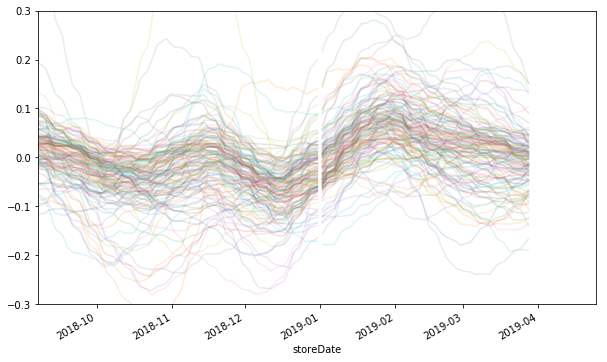

In [226]:
Y[sector_mapper['Healthcare']].tail(252).plot(
    figsize=(10,6), alpha=0.15, ylim=(-.3, .3), legend=False)

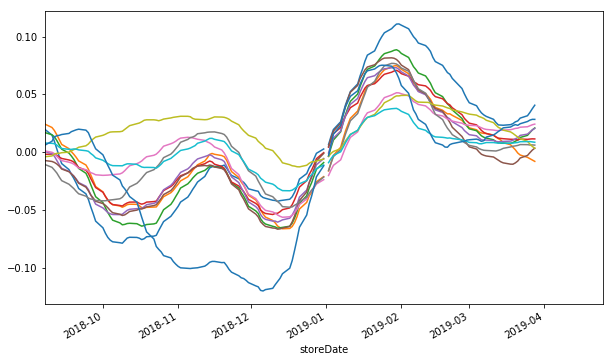

In [227]:
for s in sectors: Y[sector_mapper[s]].tail(252).mean(1).plot(figsize=(10,6))

In [ ]:
y_outliers = Y.loc[(Y > 1).any(1).values, (Y > 1).any().loc[(Y > 1).any()].index]
y_outliers.max().sort_values()

In [18]:
features = X_train.shape[1]

# RandomForestClassifier
params = {
    'n_estimators': 50, 'max_features': features, 'max_depth': 30,
    'min_samples_split': 2, 
    'random_state': 1, 'n_jobs': -1}

rfc = RandomForestClassifier(**params).fit(X_train, y_train)
scores = rfc.score(X_train, y_train), rfc.score(X_test, y_test)
print(scores)

(0.9960288141854451, 0.6626038781163435)


In [19]:
# ExtraTreesClassifier
params = {
    'n_estimators': 50, 'max_depth': 30,
    'min_samples_split': 2, 'min_samples_leaf': 1,
    'random_state': None, 'n_jobs': -1}

etc = ExtraTreesClassifier(**params).fit(X_train, y_train)
scores = etc.score(X_train, y_train), etc.score(X_test, y_test)
print(scores)

(0.9970908755079424, 0.6587257617728531)


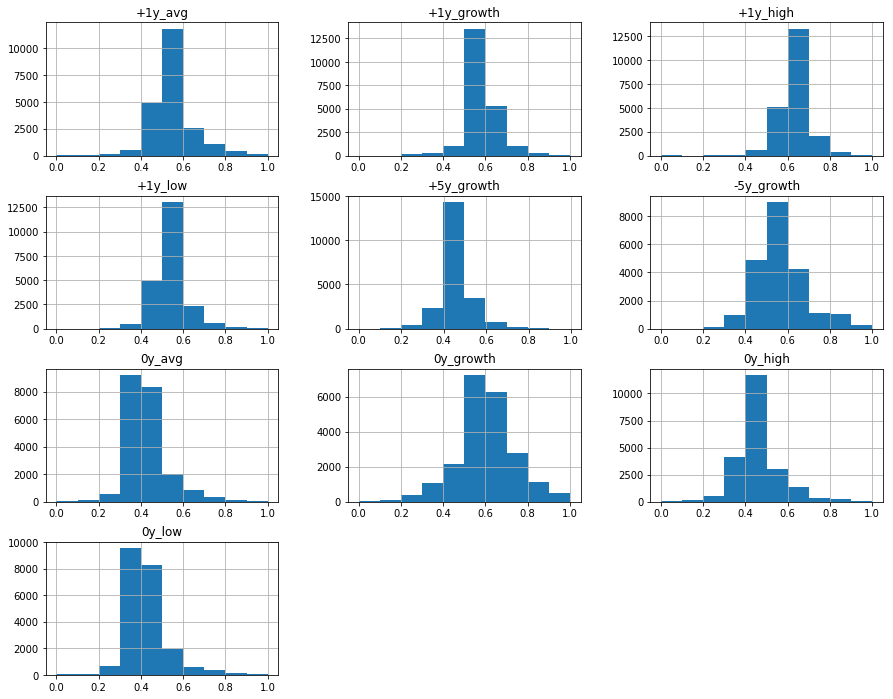

In [20]:
X_train.hist(figsize=(15,12));

In [21]:
%%time
# MLPClassifier
params = {
    'solver': 'lbfgs', 'max_iter': 200, 'activation': 'relu', 
    'alpha': 0.001, 'hidden_layer_sizes': (features - 1, 5),
    'learning_rate': 'adaptive', 'random_state': None, 'verbose': True,}

mlpc = MLPClassifier(**params).fit(X_train, y_train)
scores = mlpc.score(X_train, y_train), mlpc.score(X_test, y_test)
print(scores)

(0.3139083856667898, 0.31560480147737763)
CPU times: user 6.74 s, sys: 982 ms, total: 7.72 s
Wall time: 1.36 s


#### Metrics

Feature ranking:
39 feature fiftyDayAverageChangePercent (0.13894538386557223)
72 feature PctMA50 (0.11254266927461412)
75 feature PctChg20 (0.08822558257358028)
80 feature rsBench20 (0.07213953982565484)
74 feature RollVol30 (0.03496587366055478)
81 feature rsSect20 (0.0340876024919688)
82 feature rsBench60 (0.02319553684016019)
76 feature PctChg60 (0.020830627535985337)
40 feature twoHundredDayAverageChangePercent (0.01623283841357299)
79 feature Pct52WkL (0.01618768652281214)
78 feature Pct52WkH (0.011043691127340506)
42 feature fiftyTwoWeekLowChangePercent (0.010764093819782444)
83 feature rsSect60 (0.010656604533140282)
41 feature fiftyTwoWeekHighChangePercent (0.0100273480163043)
77 feature PctChg120 (0.00998784329517619)
85 feature rsSect120 (0.009201565248485508)
84 feature rsBench120 (0.00897199388455194)
21 feature targetMedianPrice (0.008523793075843038)
45 feature priceToBook (0.008500119154014687)
73 feature PctMA200 (0.008238867781577274)
46 feature marketCap (0.008137165

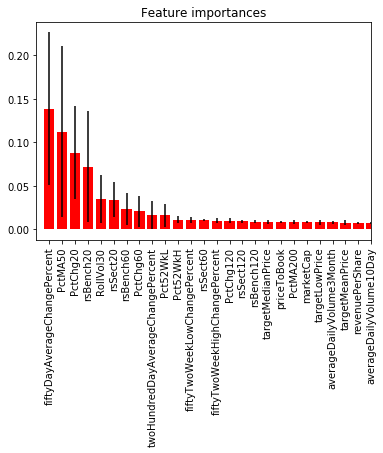

In [625]:
show_fi(clf1, X_train, 25)

In [626]:
print('Confussion Matrix\n', confusion_matrix(clf1.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[   44     6     0     0     0]
 [   13  1025   144     2     0]
 [    0   381 11020   297     5]
 [    0     0   237  1334    16]
 [    0     0     0    10    50]]


In [627]:
print('Classificaton report\n', classification_report(clf1.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.77      0.88      0.82        50
       short       0.70      0.83      0.76        60
     neutral       0.81      0.84      0.83      1587
        long       0.97      0.94      0.95     11703
        bull       0.73      0.87      0.79      1184

   micro avg       0.92      0.92      0.92     14584
   macro avg       0.80      0.87      0.83     14584
weighted avg       0.93      0.92      0.93     14584



In [629]:
log_loss(y_test, clf1.predict_proba(X_test))

0.3642648577874384

#### Gridsearches

In [ ]:
# np.arange(10, X.shape[1], int(X.shape[1]*.25))

In [ ]:
# %%time
# # GridSearchCV for RandomForestClassifier
# parameters = {
#     'n_estimators': [10, 40, 80], 
#     'max_features': np.arange(10, X.shape[1], int(X.shape[1]*.25)), 
#     'random_state': np.arange(1, 10, 3)}

# # parameters = {
# #     'n_estimators': [40], 
# #     'max_features': [30], 
# #     'random_state': [1]}

# clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)
# clf.fit(X_train, y_train)

# print(clf.score(X_train, y_train), clf.score(X_test, y_test))
# print(clf.best_params_)

In [ ]:
# %%time
# # GridSearchCV for MLPClassifier

# parameters = {
#     'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
#     'max_iter': [200], # [200, 400, 600]
#     'activation': ['relu'], # ['logistic', 'tanh', 'relu']
#     'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
#     'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
#     'hidden_layer_sizes': np.arange(5, 50, 10), # np.arange(5, 50, 10)
#     'random_state': np.arange(0, 10, 3)} # np.arange(0, 10, 2)

# parameters = {
#     'solver': ['lbfgs'], 
#     'max_iter': [200], 
#     'activation': ['relu'], 
#     'alpha': [0.01], 
#     'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
#     'hidden_layer_sizes': [ 45 ], # np.arange(5, 50, 10)
#     'random_state': [0] } # np.arange(0, 10, 2)

# clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5)
# clf.fit(X_train, y_train)

# scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
# print(scores)
# print(clf.best_params_)